# Tutorial

This Jupyter Notebook is a hands-on walkthrough demonstrating how to use the provided data routes and the `PlotKit` class to explore and expand our findings yourself. You'll learn what each data object represents, how they relate to one another, and how to leverage the visualization functions to analyze the coal fleet dataset.

All workflows are built on the open-source Python package [`retire`](https://github.com/Krv-Analytics/retire), designed for flexible and reproducible analysis. Refer to the package documentation for additional details on its capabilities, as well as expanding our research method to new data sets with the [`thema`](https://github.com/Krv-Analytics/thema) package. 

---

In [3]:
# Todo: replace with pip install retire 
import sys 
sys.path.append("..")

from retire.figures import PlotKit
from retire.data import load_dataset, load_clean_dataset, load_projection, load_graph
from examples.heatmap_config import heatmap_config
from examples.dotplot_config import dotplot_config


### Getting Started

This notebook leverages the data loading utilities provided by the `retire` package to streamline analysis and visualization. The following data routes are the primary point of contact for fetching the original data objects used in the manuscript's analysis:

- **Original Coal Dataset (`load_dataset()`)**: The unprocessed, original dataset containing plant-level and generator-level information for the U.S. coal fleet.
- **Cleaned Dataset (`load_clean_dataset()`)**: A version of the dataset that has been scaled, encoded, and imputed, making it suitable for machine learning and statistical analysis.
- **UMAP Projection (`load_projection()`)**: A low-dimensional embedding of the cleaned data, generated using UMAP, which enables visualization and clustering of plants based on their attributes.
- **Thema Graph (`load_graph()`)**: A multiresolution, discrete graph object constructed from the data. This graph is the primary object of analysis in the paper, supporting community detection, component analysis, and network-based visualizations.

These data objects are loaded using the `load_dataset`, `load_clean_dataset`, `load_projection`, and `load_graph` functions, ensuring reproducibility and consistency across all analyses presented in this notebook.


In [4]:
raw_df = load_dataset()           # pandas DataFrame: original unprocessed coal plant dataset
clean_df = load_clean_dataset()   # pandas DataFrame: cleaned, encoded, and imputed dataset
projection_df = load_projection() # pandas DataFrame: UMAP low-dimensional projection of cleaned data
G = load_graph()                  # networkx Graph: multiresolution discrete graph object


The primary data objects in this notebook are tightly integrated:

- The `raw_df`, `clean_df`, and `projection_df` DataFrames are all aligned by their index, meaning that row `i` in each DataFrame refers to the same coal plant or generator. For example, `raw_df.iloc[42]`, `clean_df.iloc[42]`, and `projection_df.iloc[42]` all correspond to the *Shawnee* plant (ORISPL:  1379).
- The graph object `G` represents a network of groups or clusters of plants. Each node in `G` has a `"membership"` attribute, which is a list of integer indices. These indices indicate which rows in the DataFrames are associated with that node. For example, if `G.nodes['a']["membership"] = [1, 16, 17, 159]`, then node 'a' represents a cluster containing the plants/generators at rows 1, 16, 17, and 159 in the DataFrames.

This structure allows for seamless cross-referencing between tabular data and network-based analyses. For instance, you can aggregate or visualize attributes from the DataFrames for all members of a given graph node, or map network-derived properties back to the original plant-level data.

In [5]:
# As an example, consider the objective of finding the ORISPL code for all the Plants in the cluster represented by node 'a'. This can be done as follows:
plant_indices = G.nodes['a']['membership']
plant_orispl_codes = raw_df.iloc[plant_indices]['ORISPL'].values
print("ORISPL for Plants in Node 'a':", list(plant_orispl_codes))

ORISPL for Plants in Node 'a': [26, 628, 645, 7242]


### Getting Aquainted with the PlotKit object


This section will serve as a hands-on tutorial for both using the `retire` code base and reproducing the exact configurations and visualizations featured in the manuscript. By following the walkthrough, users will learn how to:

- Utilize the `PlotKit` object and associated plotting routines to generate figures analogous to those in the paper.
- Apply the same configuration dictionaries (`heatmap_config`, `dotplot_config`) used in the manuscript to ensure consistency and reproducibility.
- Understand the workflow for aggregating, visualizing, and interpreting coal plant data in the context of energy system transitions.

Whether you are seeking to replicate the published results or adapt the methods for your own research, this tutorial provides a step-by-step guide to the analytical and visualization capabilities of the `retire` package.

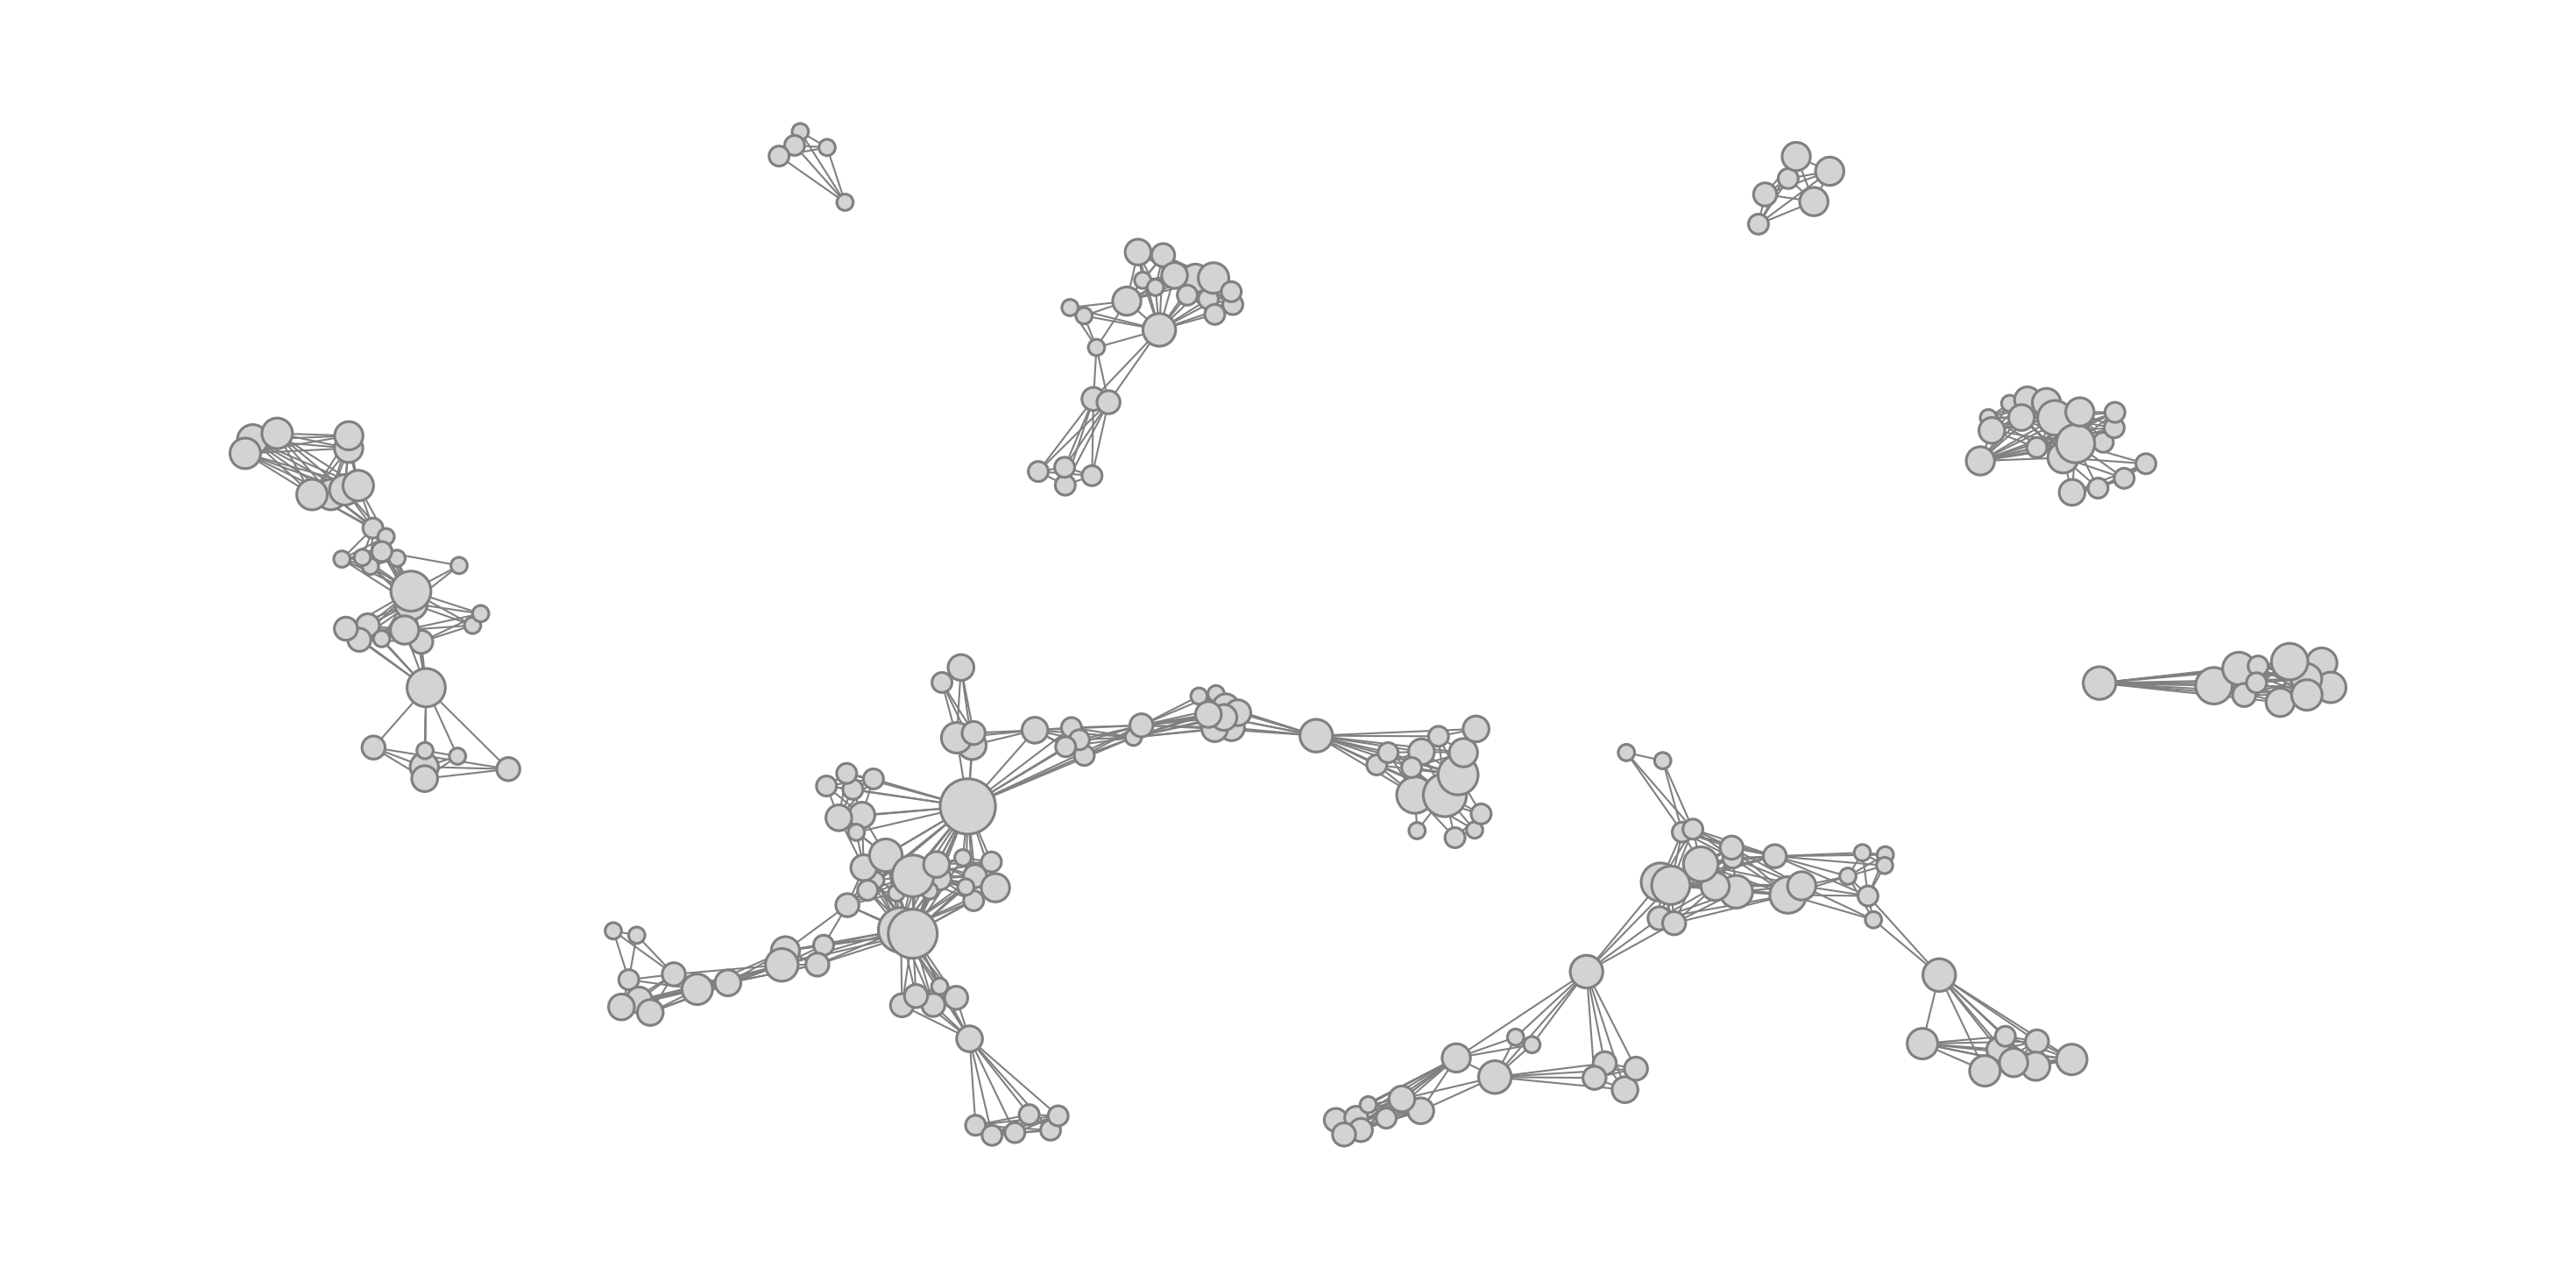

In [6]:
plotkit = PlotKit(G=G, raw_df=raw_df) # for more information on the PlotKit objects - check out our documentation! 
fig, ax = plotkit.drawGraph()

### Our Visualizations 

A core feature of the `retire` package is the ability to visualize explicit plant-level data alongside graph-based representations of the coal fleet. By combining topological structure (from the graph) with statistical summaries and feature-level data, our visualization tools enable users to explore how plant attributes, operational metrics, and social/environmental indicators relate to network structure at multiple scales. This integrated approach provides deeper insights into the drivers of coal plant clustering, retirement patterns, and system-level transitions, supporting both exploratory analysis and reproducible figure generation for publication.

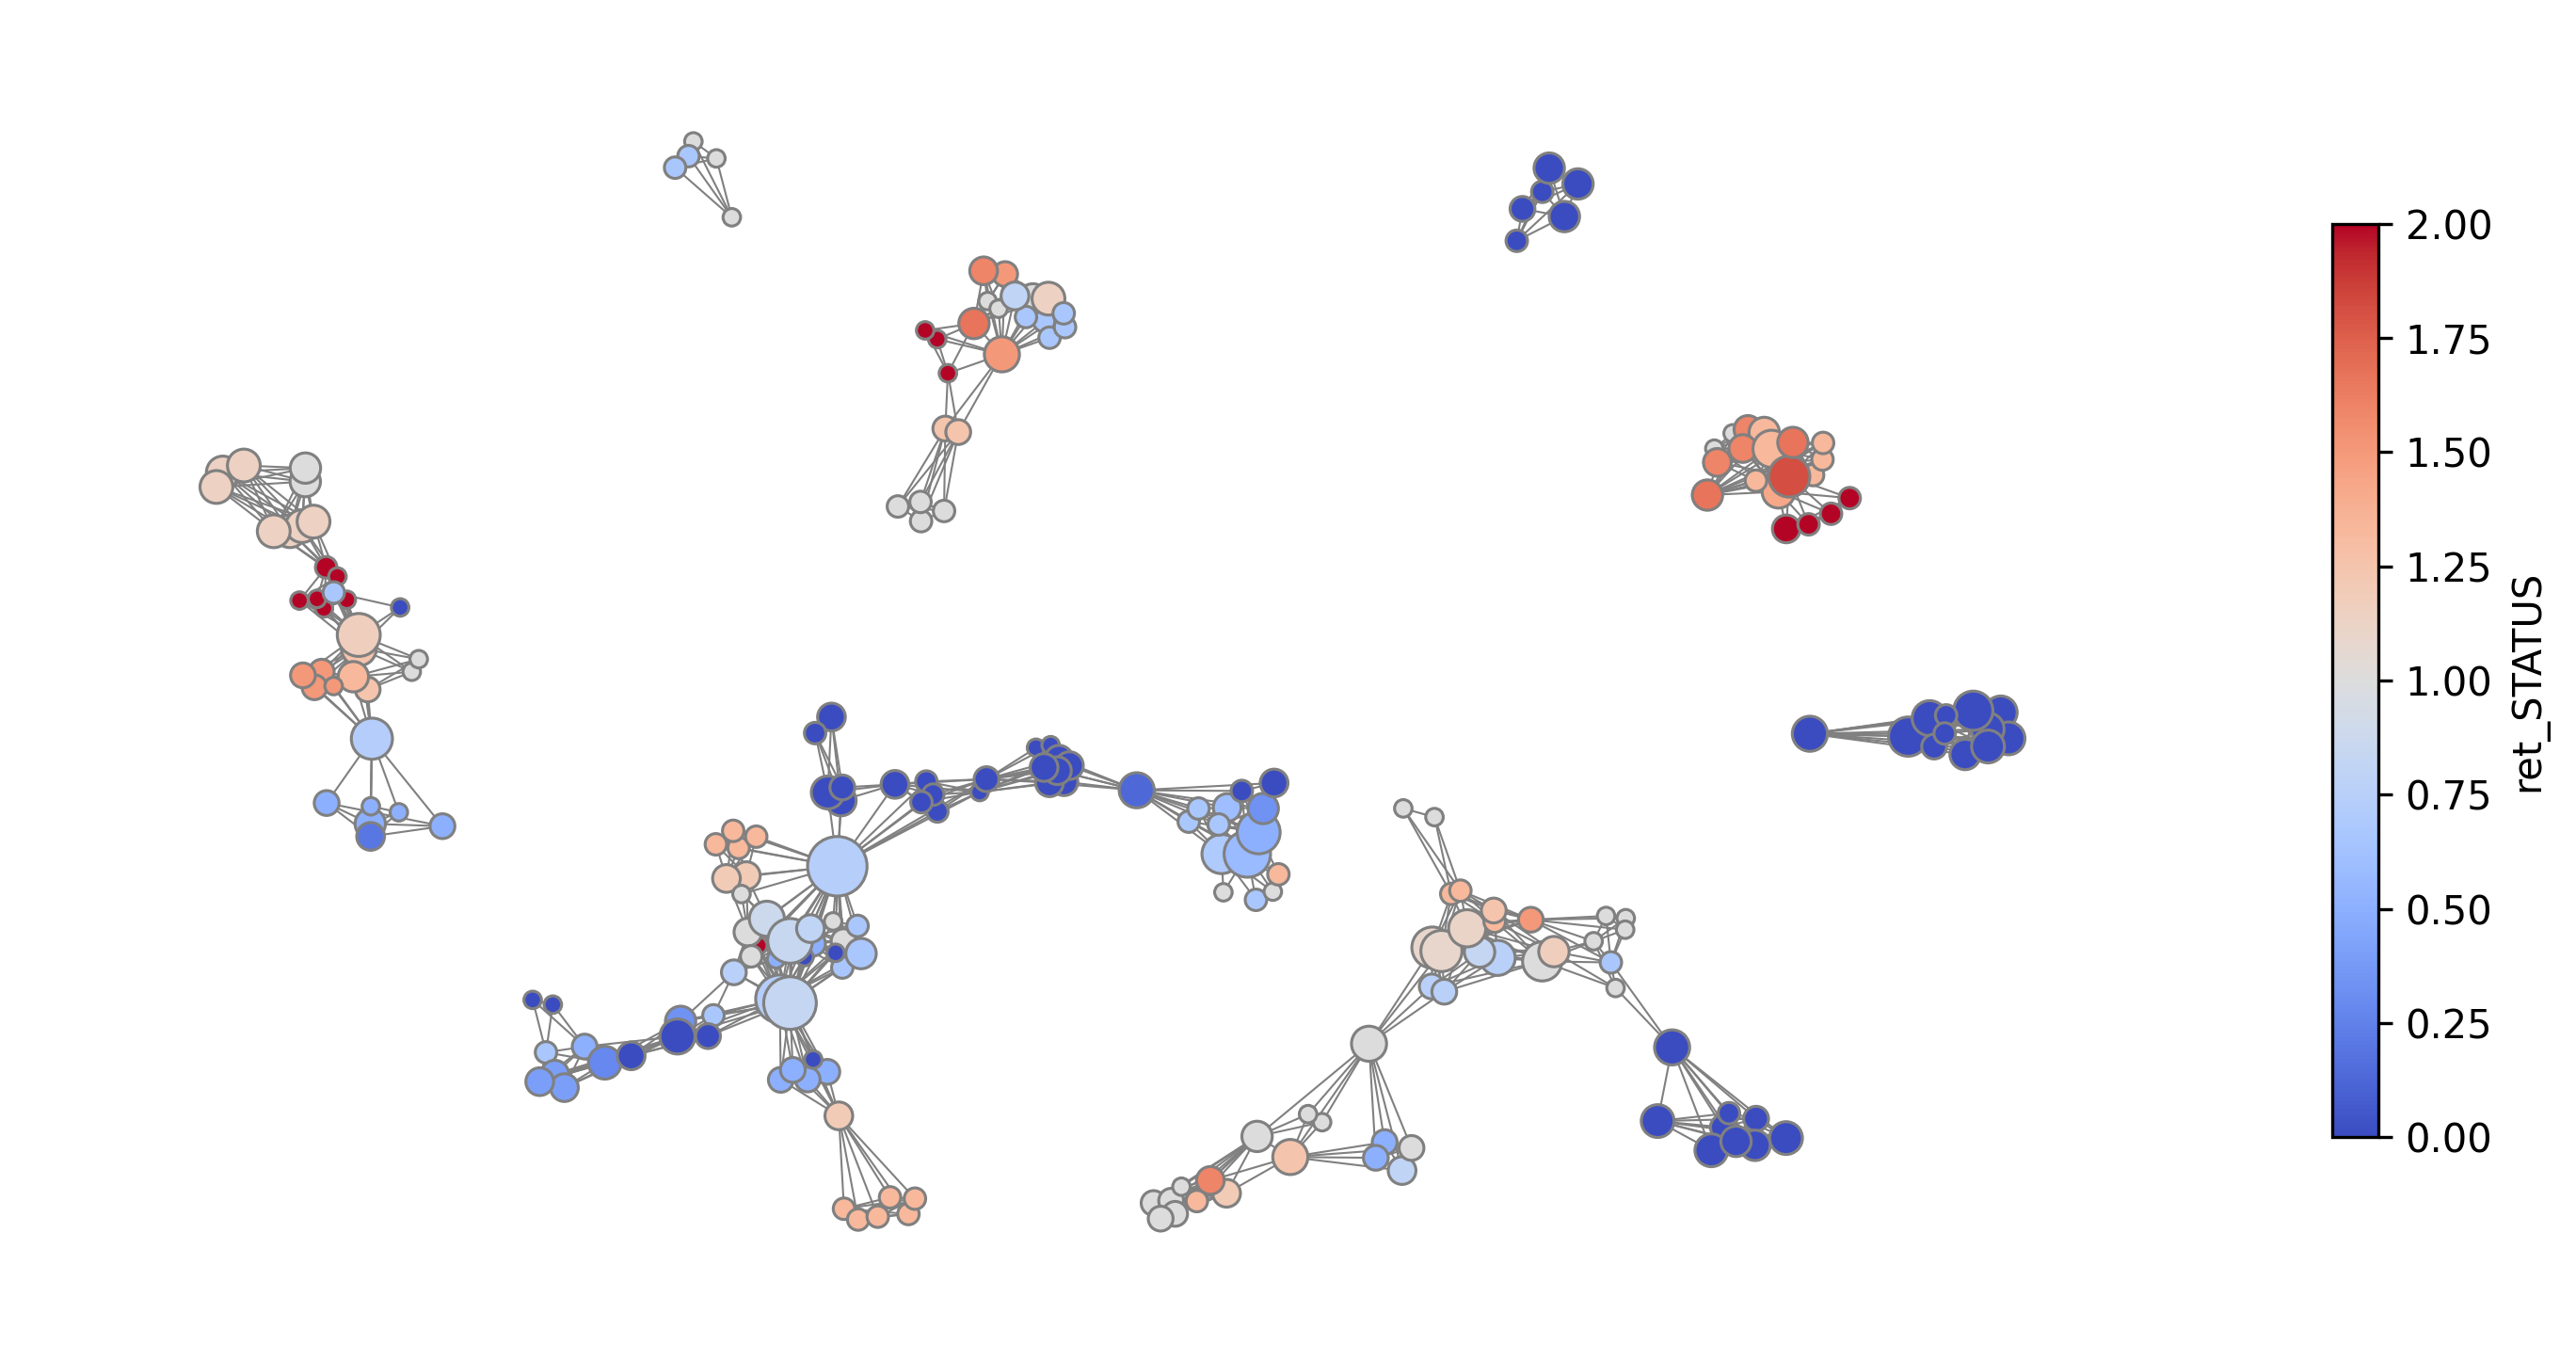

In [7]:
fig, ax = plotkit.drawGraph(show_colorbar=True,  col = "ret_STATUS", color_method="average") # This is the configuration used in Figure 2 of the manuscript 

### Investigating Individual Graph Components

(Aside: we will often use the terminology 'Component' instead of 'Group' when in the context of graphs- this is the standard terminology used in Graph Theory literature and often feels more natural when describing these objects. Similarly, we often interchange 'Node' and 'Cluster', as our framework uses nodes in the graph to represent clusterings (finer grained groupings) of Coal Plants)

To gain more fine-grained intuition and conduct targeted analysis, it is often useful to focus on specific components (subgraphs) within the overall network. By isolating and visualizing these components, we can better understand the unique characteristics, operational patterns, and social or environmental factors that define each group.

The `drawComponent` function enables this level of analysis by allowing users to select and visualize any individual component of the graph. This approach supports detailed exploration of plant clusters, facilitates comparison between groups, and helps uncover localized drivers of coal plant retirement and transition.


For example, say you wanted to investigate how a plant's age varies across Component (Group) 0, or where high concentrations of Retiring Coal Plants concentrate in Component (Group) 3. 


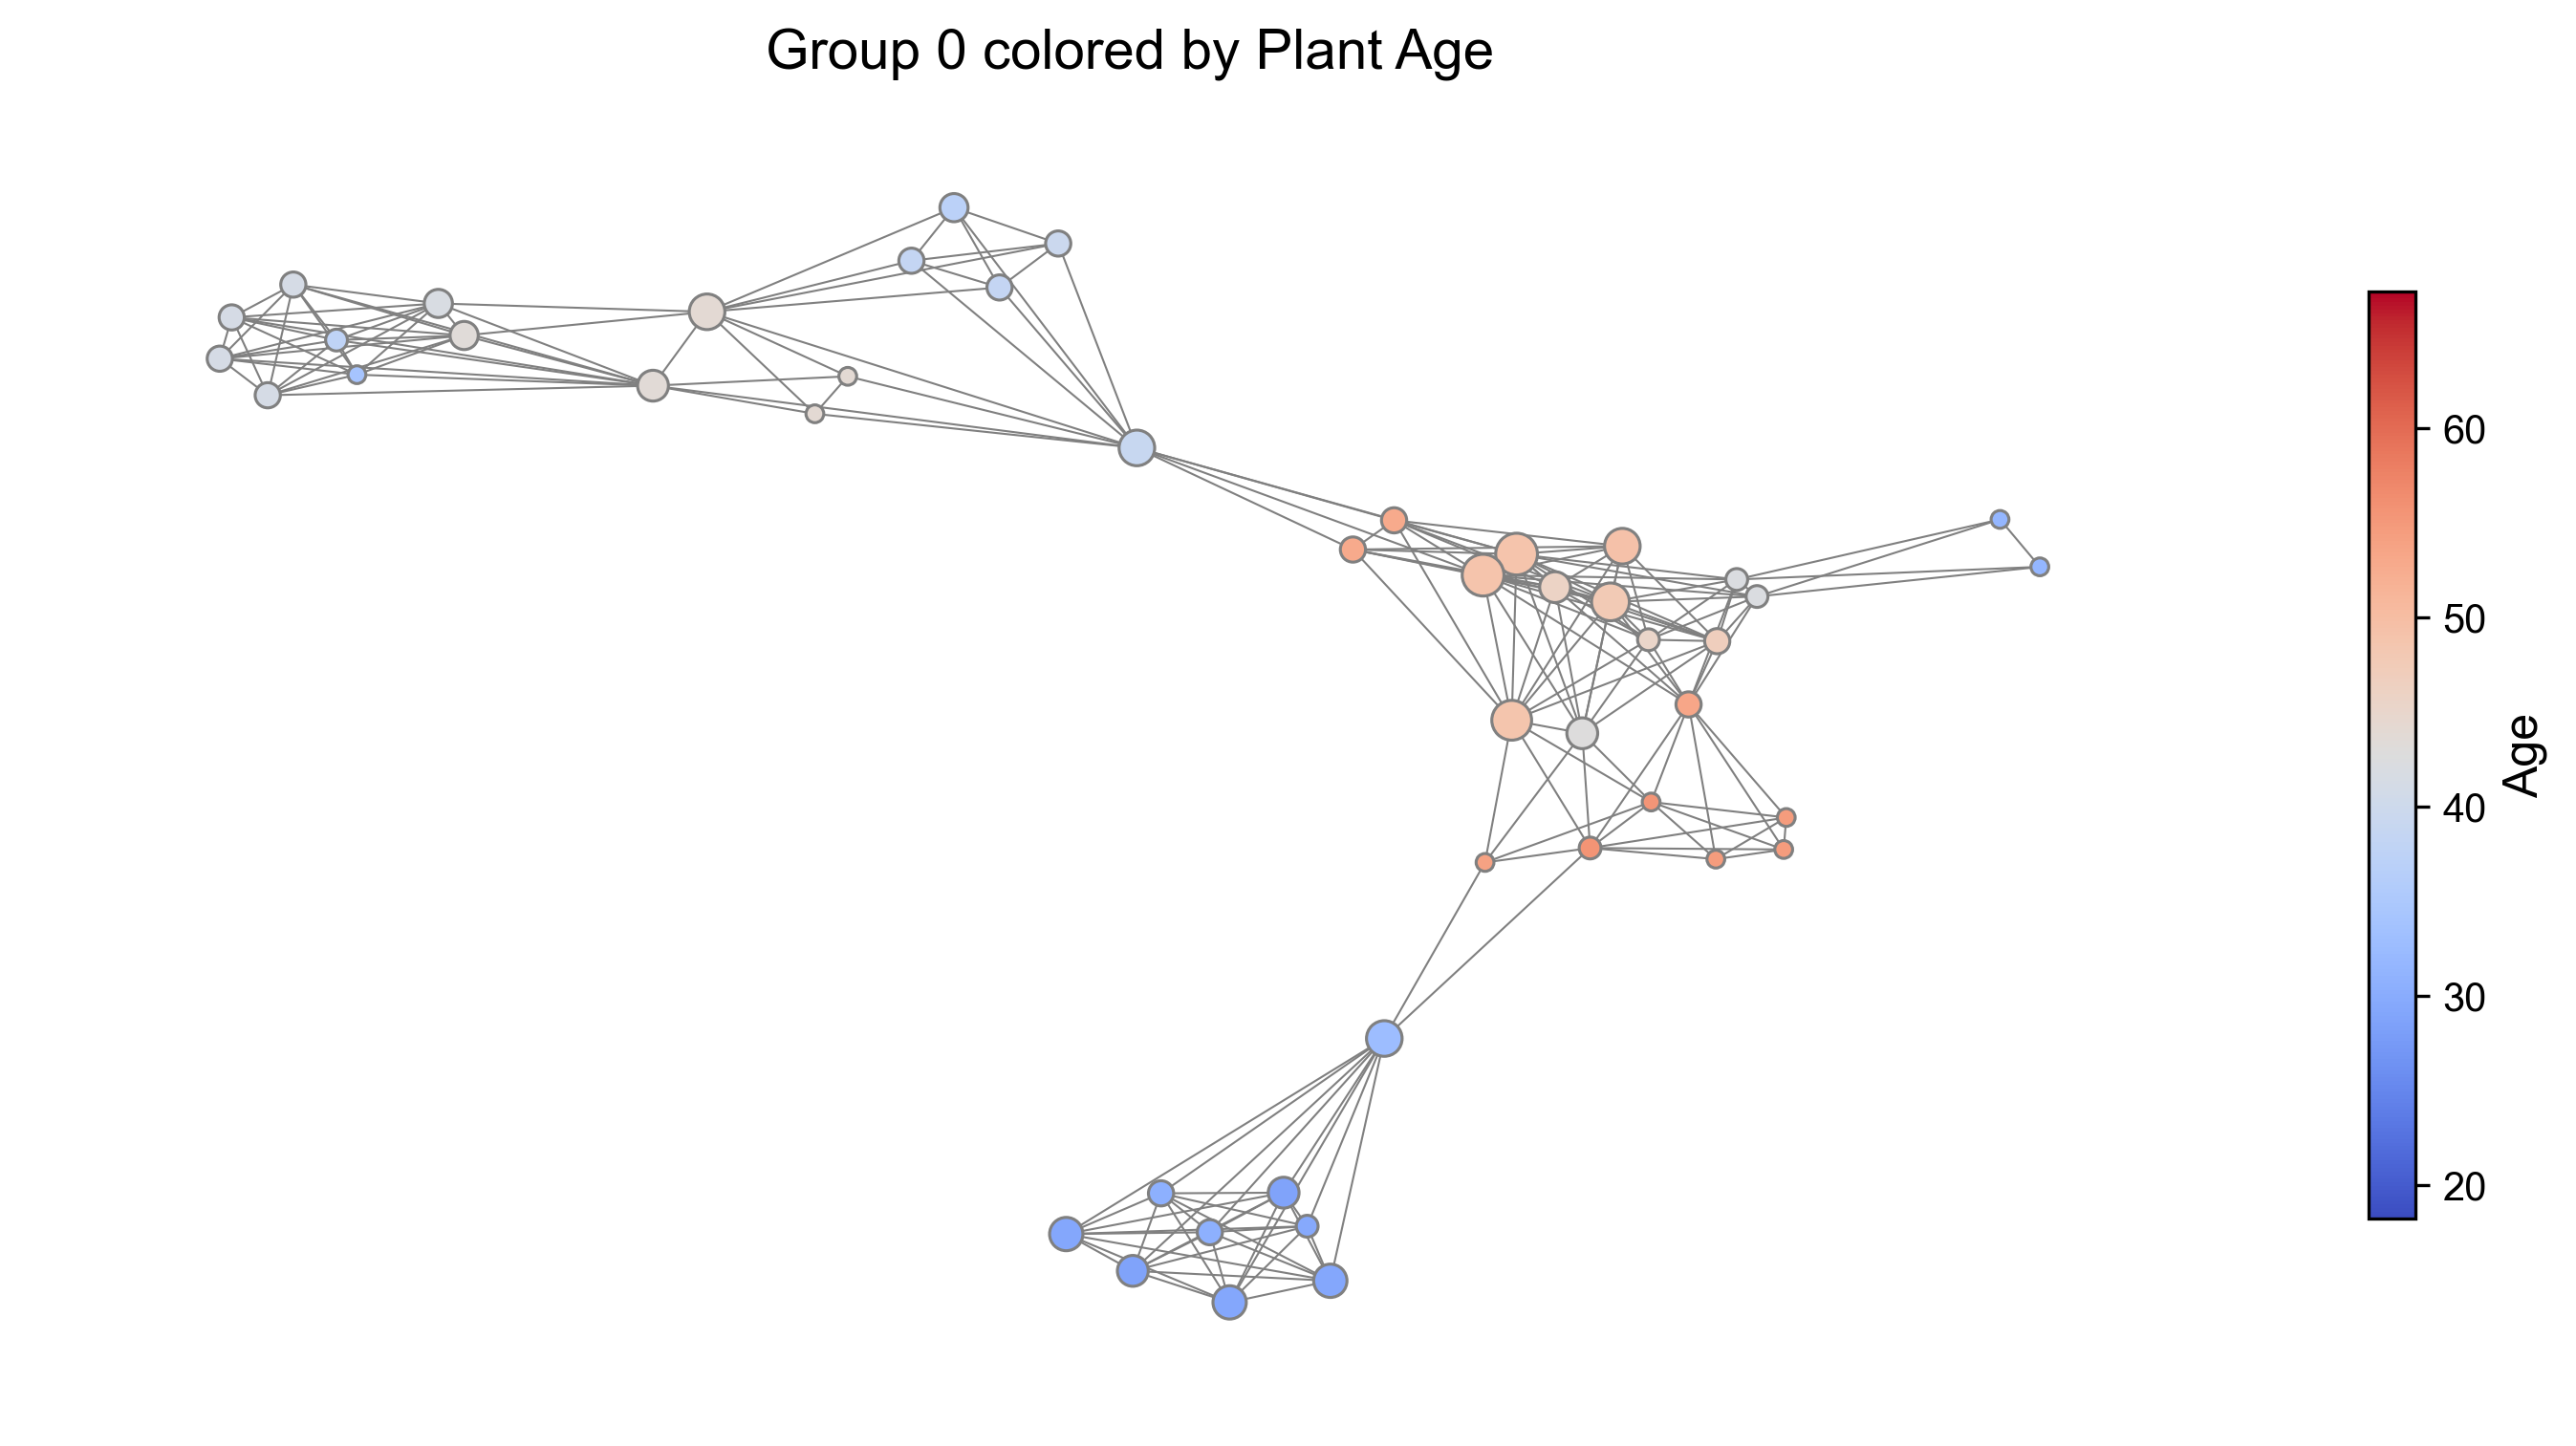

In [25]:
fig, ax = plotkit.drawComponent(component=0, show_colorbar=True, col="Age", title="Group 0 colored by Plant Age") 

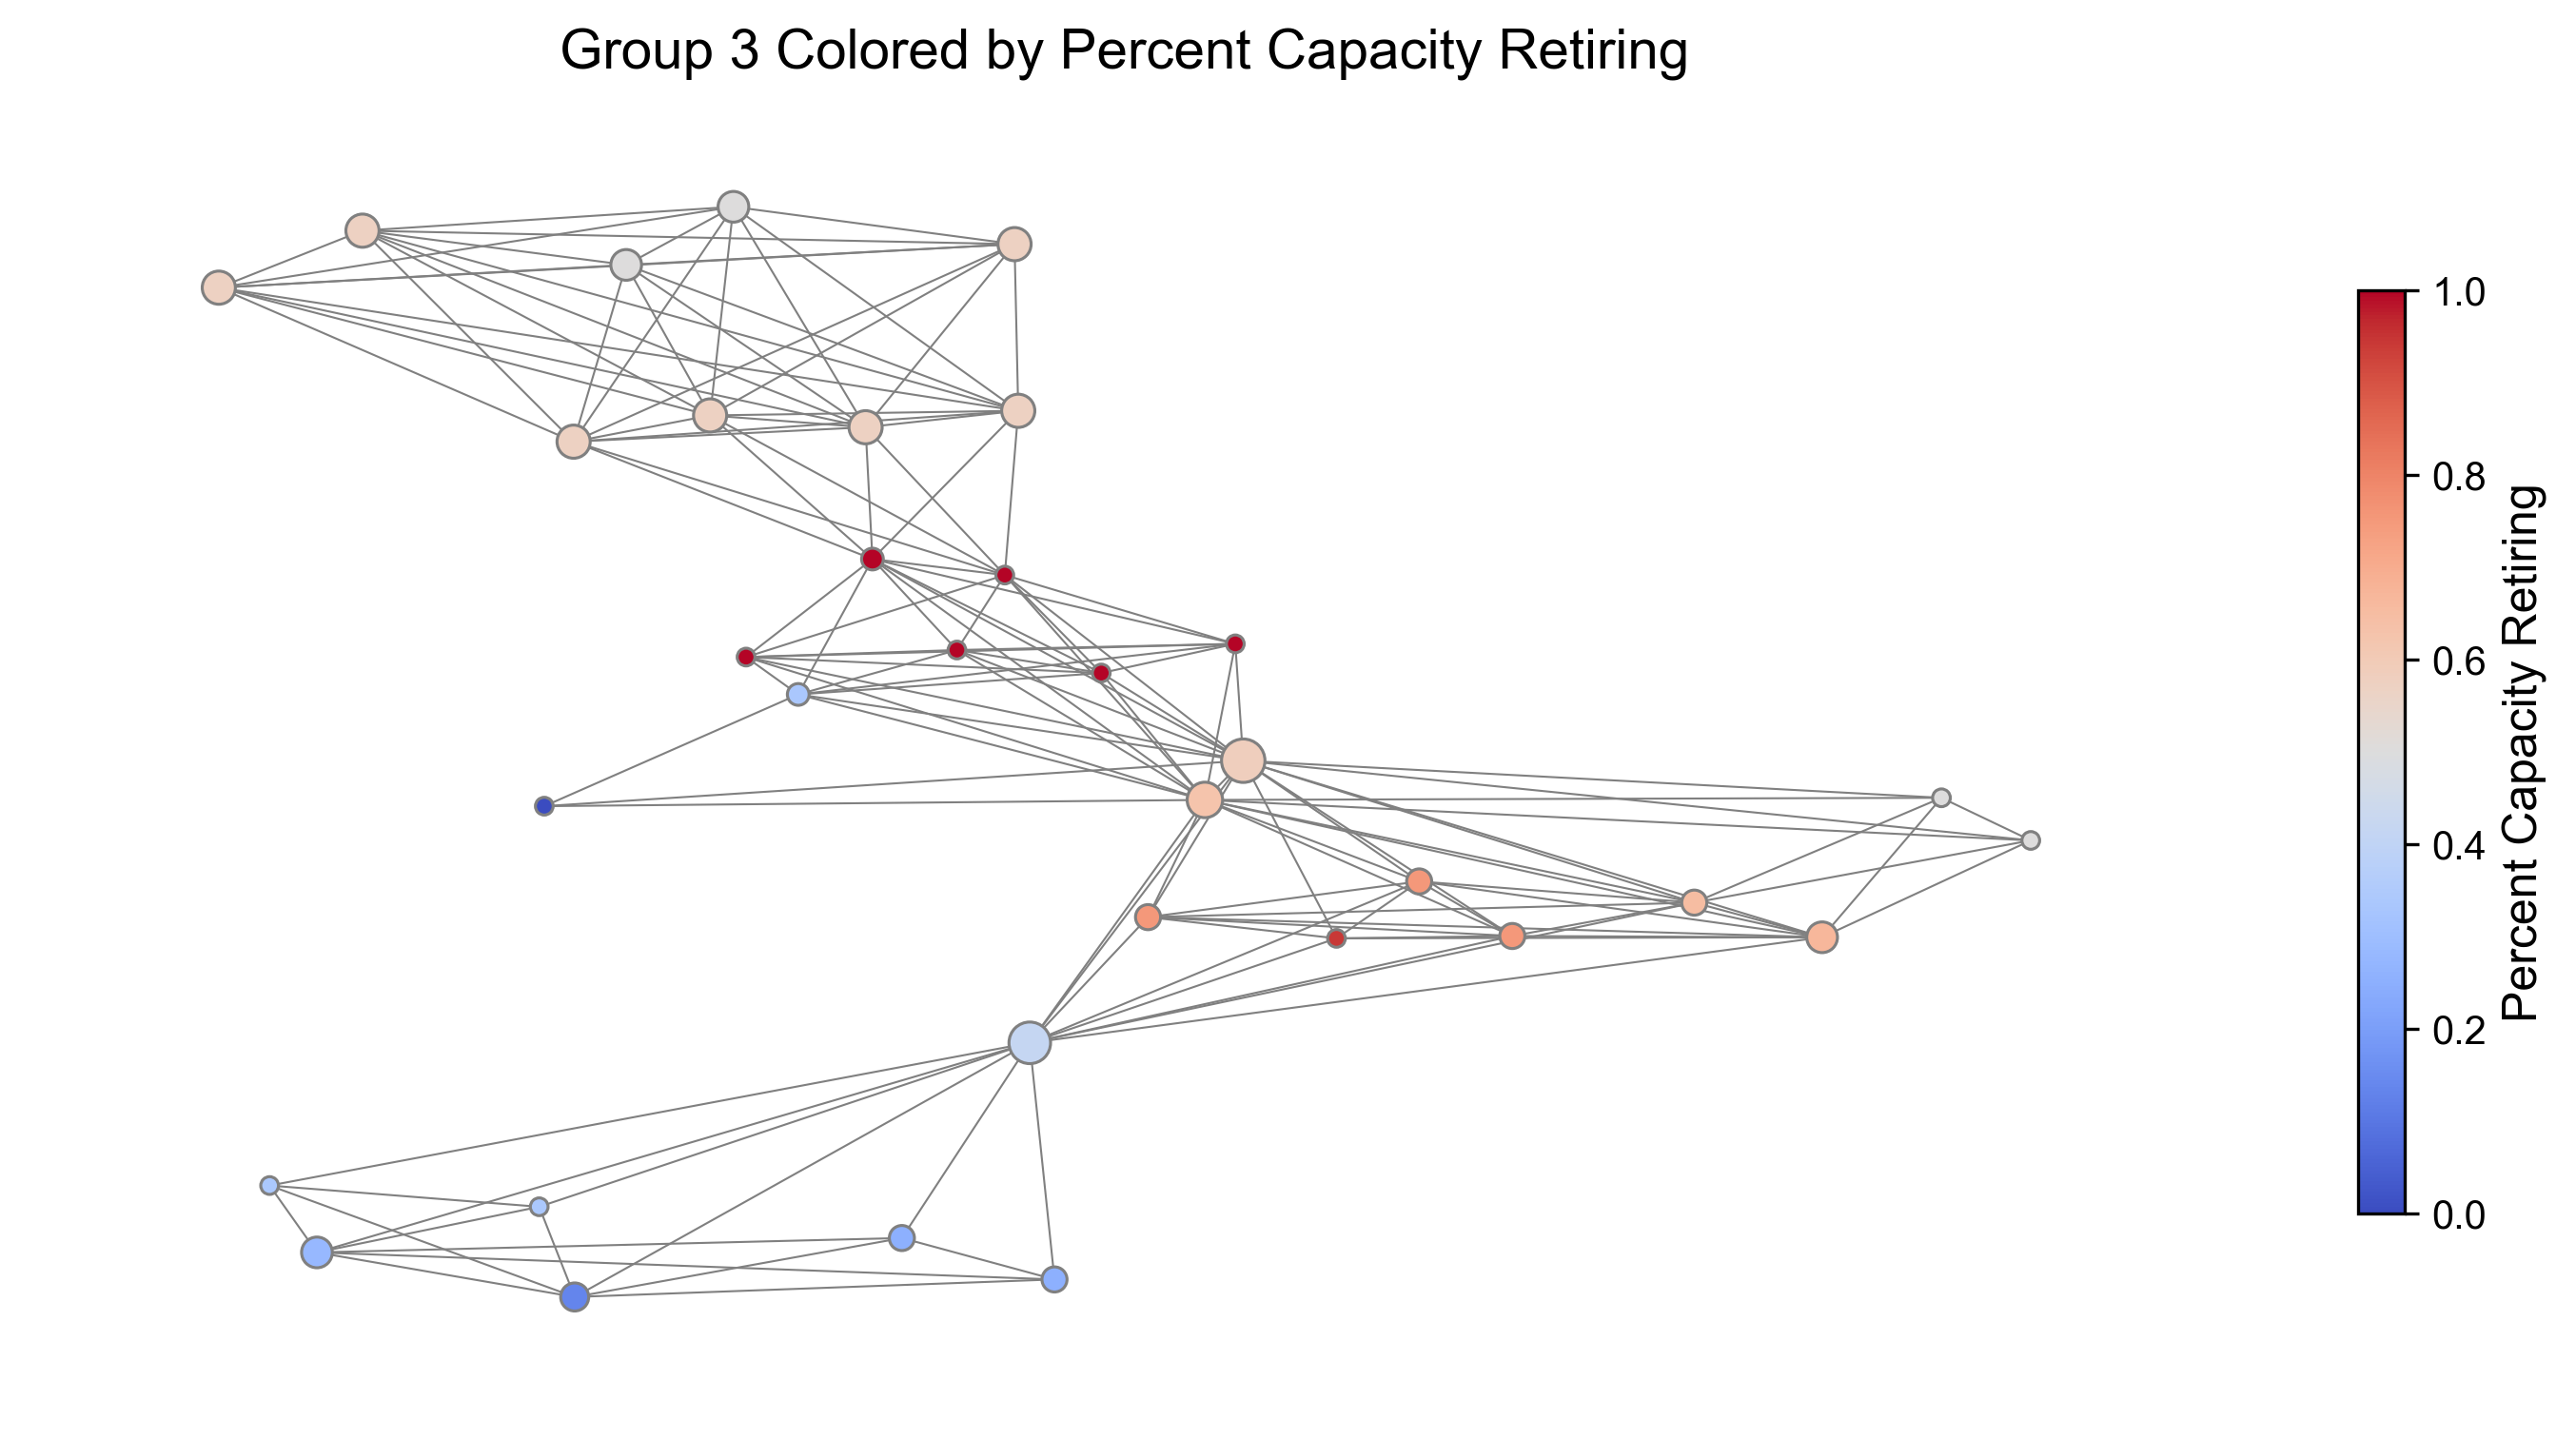

In [24]:
fig, ax = plotkit.drawComponent(component=3, show_colorbar=True, col="Percent Capacity Retiring", title="Group 3 Colored by Percent Capacity Retiring")

## Graph Metrics

### Further Clustering Via Label Propagation 

A considerable advantage to a graph based representation is access to a multitude of analytic algorithms supported by the graph theory community. Since our underlying representation is simply a networkx graph with node features, we gain immediate access to a well maintained code base implementing these algorithms. One such algorithm is community detection via label propagation. That is, using the inherent structure of the graph, we can further divide connected components into smaller communities for more granular analysis. 

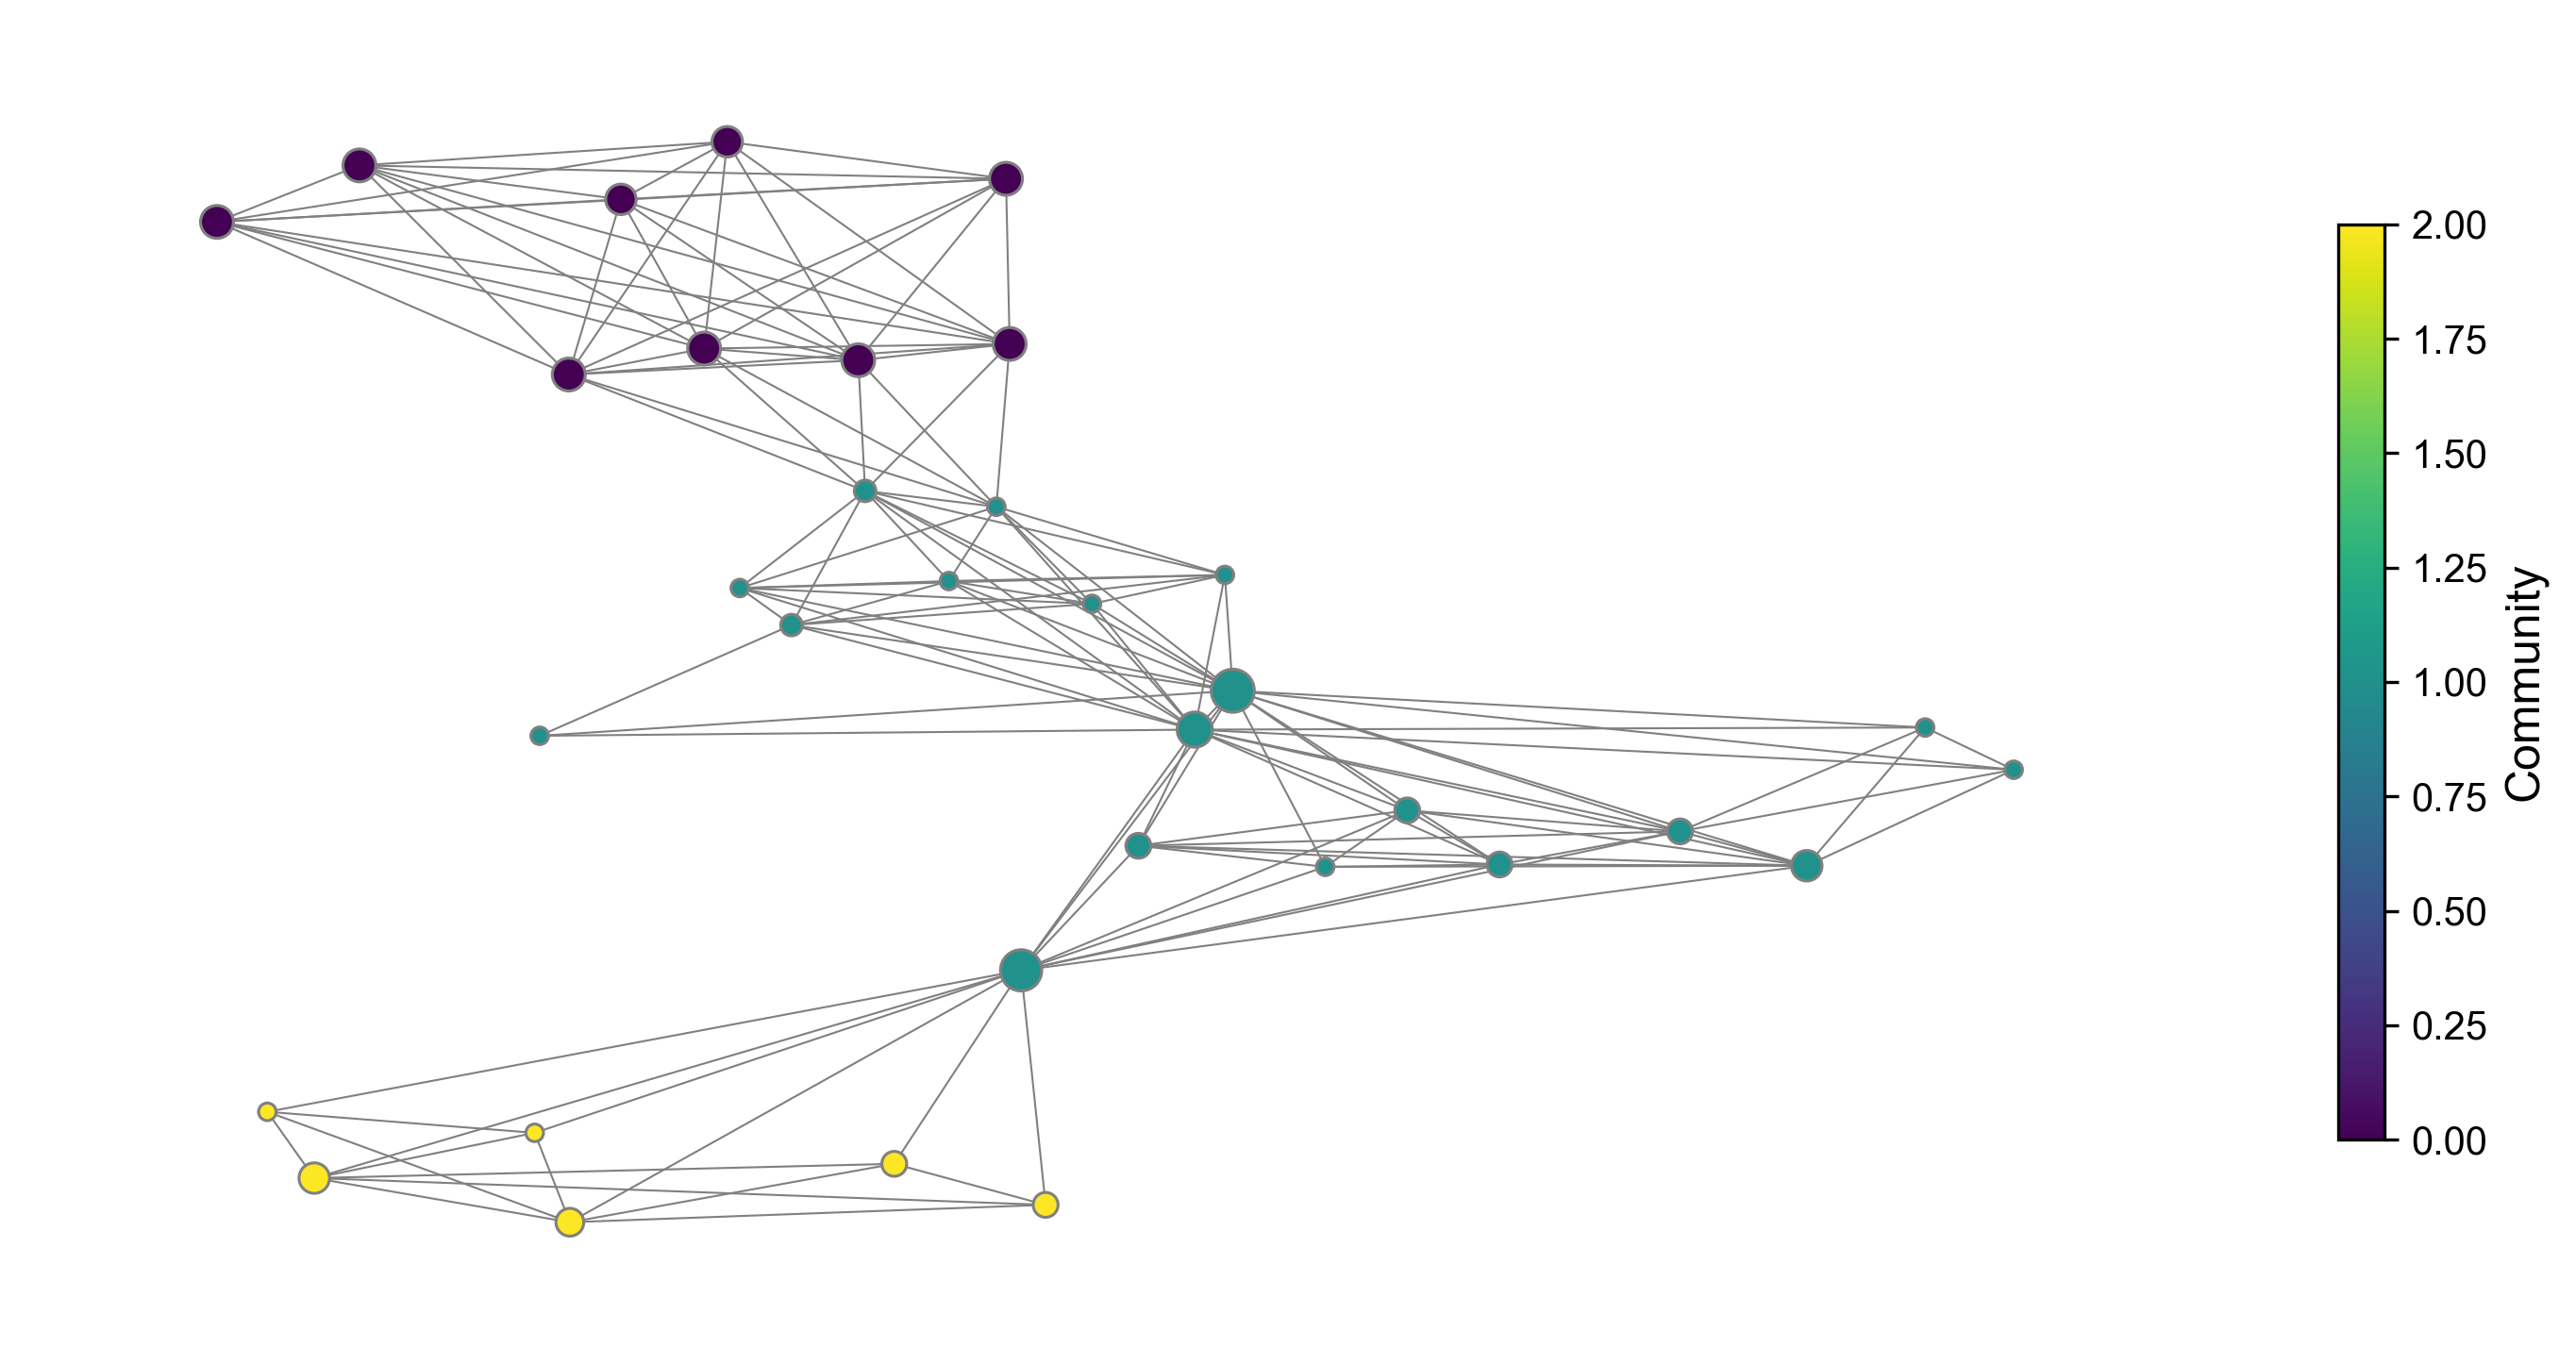

In [26]:
fig, ax = plotkit.drawComponent(component=3, col="ret_STATUS", show_colorbar=True, color_method="community")

### Quantifying Proximity to Retirement

Graphs provide a natural framework for defining distances—such as the shortest path between two nodes—enabling us to rigorously quantify relationships within the coal plant network. In our analysis, we are particularly interested in understanding how "close" or "far" a plant is from retirement, not just in attribute space, but in terms of its position within the network.

To achieve this, we first identify which nodes in the graph contain retiring plants, which is determined by the column `Percent Capacity Retiring`, and assess what proportion of each node's members are retiring. The intuition is straightforward: if a plant is grouped in a node with many retiring plants, it is likely close to retirement itself, sharing strong data similarities with those retiring archetypes. Conversely, if a plant is several steps away—meaning the shortest path through the network to any node with retiring plants is long—it is more distinct from the typical retiring plant profile.

This graph-based distance metric allows us to move beyond simple attribute comparisons, providing a nuanced, topology-aware measure of how "retirement-like" each plant is within the broader system.


In the next example, we will explicitly compute which nodes are identified as `target nodes` in Component (Group) 4. A node is labeled as a target if the percentage of retiring capacity among its members exceeds the set `threshold = 0.5`. We then calculate, for each plant in the component, the shortest path distance to the nearest target (retiring) node. This approach quantifies how "close" each plant is, in network terms, to a node characterized by high retirement activity.



### Interpreting the Path Distance Graph

Nodes that are visually or topologically "far away" from any target nodes have the largest path distances. These represent groups of plants that, from a data perspective, are most distinct from the typical retiring plant profile. In other words, the farther a node is from any target node, the less similar its members are to those in high-retirement clusters—making them less likely to retire soon based on the features used in the analysis. This network-based distance offers a nuanced, topology-aware measure of proximity to retirement within the coal plant system.

--- 
On Your Own: 

If you decrease the threshold (i.e., loosen the criteria for classification as a target), more nodes will be labeled as targets, reflecing a broader definition of high retirement activity. Conversely, a higher threshold results in fewer target nodes, focusing only on those with the most concentrated retirement. Try setting `threshold=0.2` and see how the PathDistance plot changes. 

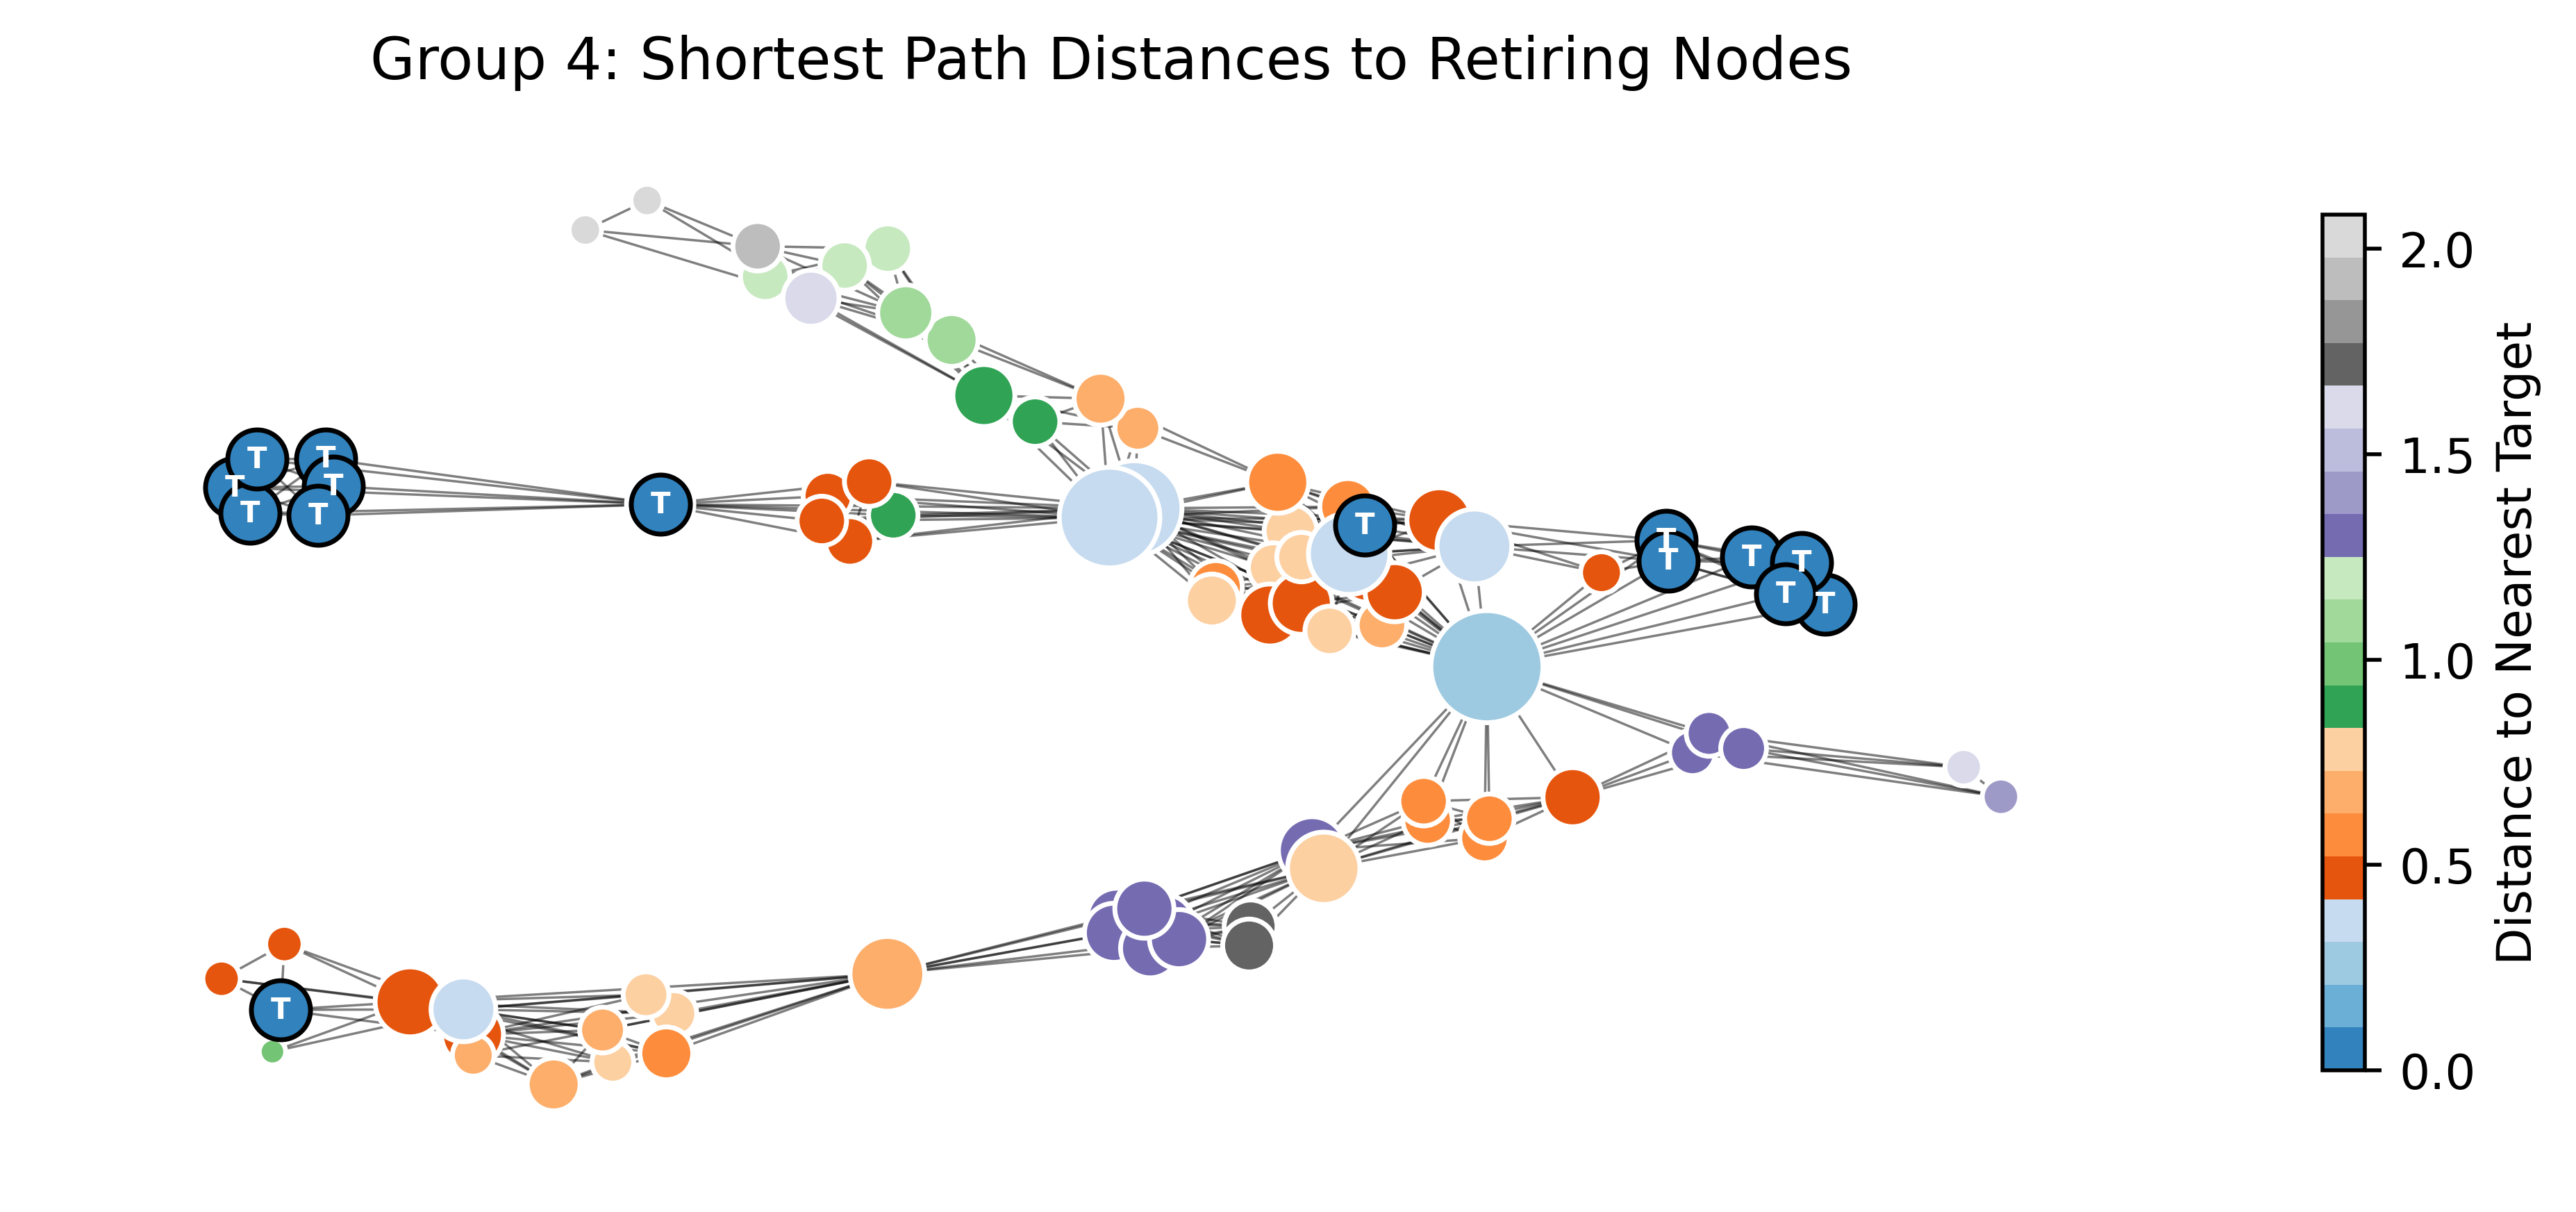

In [10]:
component = 4
threshold = 0.5 
col = "Percent Capacity Retiring"
retiring_nodes = plotkit.get_target_nodes(component=component,  col=col, threshold=threshold)
node_distances = plotkit.get_shortest_distances_to_targets(component=component, targets=retiring_nodes)
fig, ax = plotkit.drawPathDistance(component=component, 
                    targets=retiring_nodes, 
                    distances_dict=node_distances, 
                    title=f"Group {component}: Shortest Path Distances to Retiring Nodes",
                    seed=5, 
                    show_colorbar=True) 


### Global Analysis 

While diving deeper into individual components and subcomponents allows us to uncover fine-grained patterns and local distinctions, it is equally important to maintain a holistic view of the entire coal plant landscape. Our analysis identified 8 major components (or "Groups") within the network. A key objective is to understand why these `8 groups` emerge from the data, how they relate to one another, and what it means for a plant to belong to one group versus another.

---
#### HeatMaps 

Viewing a heatmap of aggregated raw data statistics across components allows us to visually compare how key operational, environmental, social, and economic attributes are distributed among the major groups. By summarizing metrics such as capacity, emissions, age, or population exposure for each component, the heatmap highlights which features are most concentrated or distinctive in particular groups. This makes it easy to spot patterns—such as one group having older plants, higher emissions, or greater social impact—providing a clear, data-driven basis for interpreting what defines each component. These contrasts help us hypothesize why the network clustering algorithm grouped certain plants together and support arguments about the defining characteristics and policy relevance of each group.

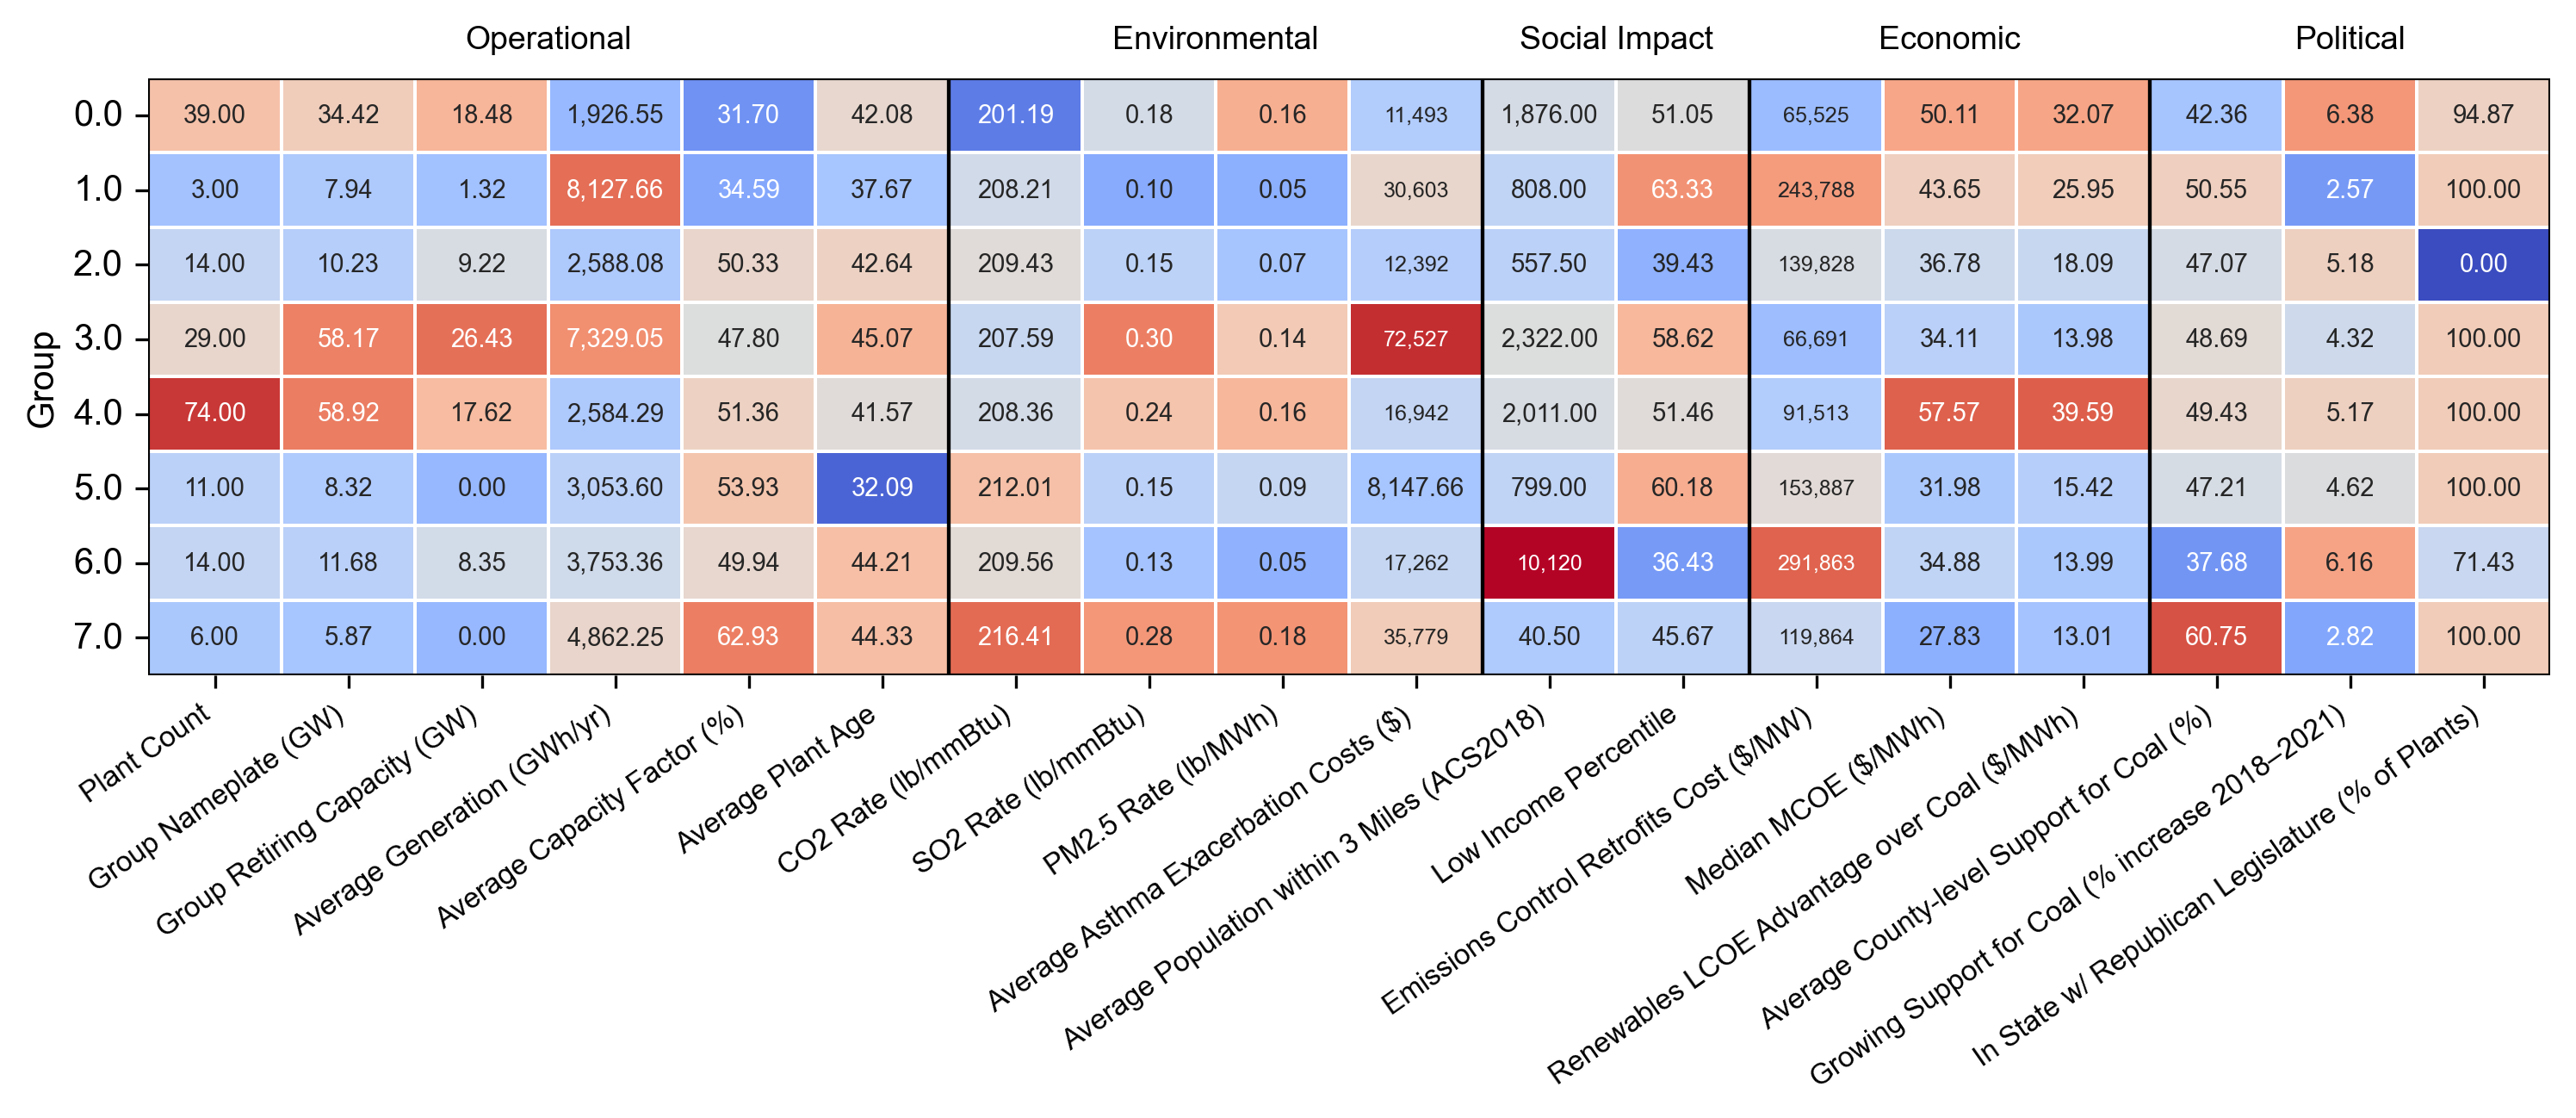

In [11]:
fig, ax = plotkit.drawHeatMap(config=heatmap_config)

### Dotplot: Standard Deviation Across Components

The dotplot visualization summarizes the standard deviation of key variables within each component of the coal plant network. By displaying the variability of each feature across plants in a group, this plot highlights which attributes are most heterogeneous (high standard deviation) and which are most homogeneous (low standard deviation) within each component.

- **High Standard Deviation:** Variables with large standard deviations within a component indicate substantial diversity among the plants in that group. These features are crucial for understanding the internal differences and the range of plant characteristics that define the component’s structure. High variability suggests these attributes are important for distinguishing subgroups or outliers within the component.

- **Low Standard Deviation:** Conversely, features with low standard deviation are relatively uniform across all plants in the component. These homogeneous variables represent shared properties and may serve as defining characteristics for why the group was formed in the first place. Such features can be interpreted as global indicators or signatures of the component.

By examining which variables are most and least variable within each group, the dotplot provides insight into the drivers of similarity and difference among coal plants, helping to interpret the underlying reasons for network clustering and the distinctiveness of each component.

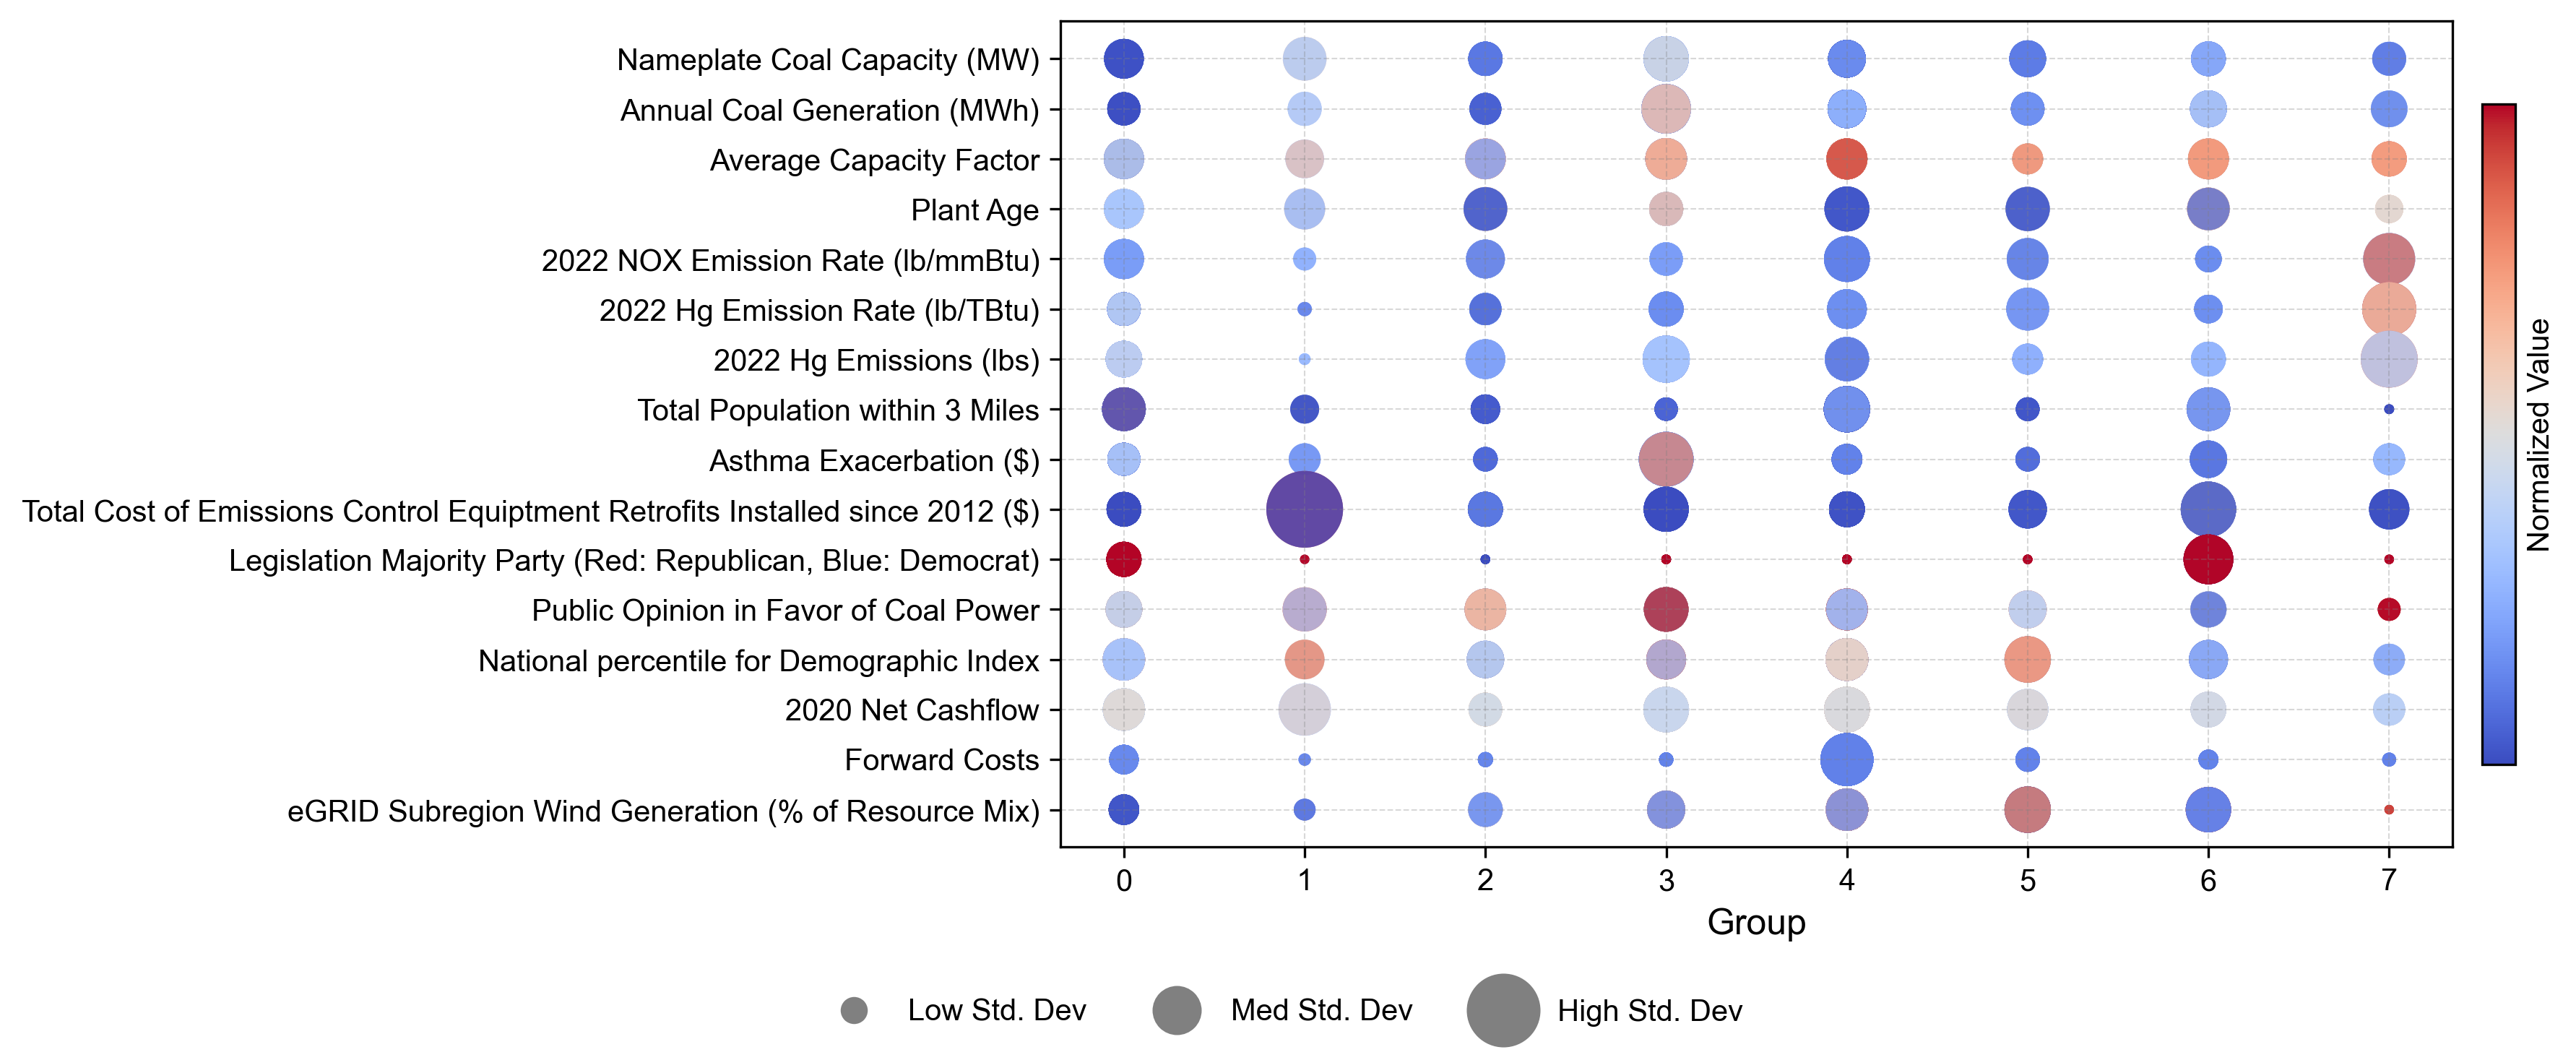

In [12]:
fig, ax = plotkit.drawDotPlot(config=dotplot_config, clean_df=clean_df)